# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1410s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.jpg')
x_data = []
y_data = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = int(target)
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1325, 32, 20, 3)
(1325, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
inputs = tf.keras.Input(shape=(32, 20, 3))
inputs2 = tf.keras.layers.BatchNormalization()(inputs)
inputs3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(inputs2)
inputs4 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs3)
inputs5 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation="relu")(inputs4)
inputs6 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs5)
inputs7 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation="relu")(inputs6)
inputs8 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs7)
inputs9 = tf.keras.layers.Flatten()(inputs8)
inputs10 = tf.keras.layers.Dense(256,activation="relu")(inputs9)
output = tf.keras.layers.Dense(11, activation='softmax')(inputs10)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

model.summary()

#model = Sequential()
#model.add(BatchNormalization(input_shape=(32,20,3)))
#model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Flatten())
#model.add(Dense(256,activation="relu"))
#model.add(Dense(11, activation = "softmax"))
#model.summary()

#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 20, 3)]       0         
                                                                 
 batch_normalization (BatchN  (None, 32, 20, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 20, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 10, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 5, 64)         0     

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.2
Rotation_Angle = 5
ZoomRange = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
332/332 [==============================] - 4s 11ms/step - loss: 2.0602 - accuracy: 0.3774
Epoch 2/500
332/332 [==============================] - 4s 11ms/step - loss: 1.3437 - accuracy: 0.5675
Epoch 3/500
332/332 [==============================] - 4s 13ms/step - loss: 0.8546 - accuracy: 0.7366
Epoch 4/500
332/332 [==============================] - 4s 11ms/step - loss: 0.6490 - accuracy: 0.7947
Epoch 5/500
332/332 [==============================] - 4s 12ms/step - loss: 0.5542 - accuracy: 0.8287
Epoch 6/500
332/332 [==============================] - 4s 13ms/step - loss: 0.4685 - accuracy: 0.8581
Epoch 7/500
332/332 [==============================] - 5s 14ms/step - loss: 0.3848 - accuracy: 0.8838
Epoch 8/500
332/332 [==============================] - 5s 15ms/step - loss: 0.4043 - accuracy: 0.8853
Epoch 9/500
332/332 [==============================] - 4s 13ms/step - loss: 0.3161 - accuracy: 0.8974
Epoch 10/500
332/332 [==============================] - 4s 13ms/step - loss: 0.314

332/332 [==============================] - 4s 12ms/step - loss: 0.0763 - accuracy: 0.9872
Epoch 81/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0637 - accuracy: 0.9849
Epoch 82/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0294 - accuracy: 0.9909
Epoch 83/500
332/332 [==============================] - 4s 13ms/step - loss: 0.0606 - accuracy: 0.9857
Epoch 84/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0476 - accuracy: 0.9879
Epoch 85/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0450 - accuracy: 0.9864
Epoch 86/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0449 - accuracy: 0.9909
Epoch 87/500
332/332 [==============================] - 4s 13ms/step - loss: 0.0201 - accuracy: 0.9940
Epoch 88/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0652 - accuracy: 0.9857
Epoch 89/500
332/332 [==============================] - 4s 13ms/step - loss: 0.0614 - 

332/332 [==============================] - 4s 12ms/step - loss: 0.0399 - accuracy: 0.9902
Epoch 160/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0599 - accuracy: 0.9864
Epoch 161/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0460 - accuracy: 0.9894
Epoch 162/500
332/332 [==============================] - 4s 13ms/step - loss: 0.0529 - accuracy: 0.9894
Epoch 163/500
332/332 [==============================] - 4s 13ms/step - loss: 0.0342 - accuracy: 0.9932
Epoch 164/500
332/332 [==============================] - 4s 13ms/step - loss: 0.0370 - accuracy: 0.9925
Epoch 165/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0354 - accuracy: 0.9879
Epoch 166/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0310 - accuracy: 0.9962
Epoch 167/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0518 - accuracy: 0.9894
Epoch 168/500
332/332 [==============================] - 4s 12ms/step - loss: 

332/332 [==============================] - 4s 12ms/step - loss: 0.0209 - accuracy: 0.9940
Epoch 238/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0140 - accuracy: 0.9970
Epoch 239/500
332/332 [==============================] - 4s 13ms/step - loss: 0.0323 - accuracy: 0.9917
Epoch 240/500
332/332 [==============================] - 4s 13ms/step - loss: 0.0307 - accuracy: 0.9947
Epoch 241/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0228 - accuracy: 0.9925
Epoch 242/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0402 - accuracy: 0.9932
Epoch 243/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0113 - accuracy: 0.9970
Epoch 244/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0136 - accuracy: 0.9962
Epoch 245/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0194 - accuracy: 0.9947
Epoch 246/500
332/332 [==============================] - 4s 12ms/step - loss: 

332/332 [==============================] - 4s 12ms/step - loss: 0.0474 - accuracy: 0.9917
Epoch 316/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0311 - accuracy: 0.9962
Epoch 317/500
332/332 [==============================] - 4s 11ms/step - loss: 0.0372 - accuracy: 0.9925
Epoch 318/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0162 - accuracy: 0.9955
Epoch 319/500
332/332 [==============================] - 4s 13ms/step - loss: 0.0343 - accuracy: 0.9970
Epoch 320/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0290 - accuracy: 0.9947
Epoch 321/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0164 - accuracy: 0.9955
Epoch 322/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0112 - accuracy: 0.9955
Epoch 323/500
332/332 [==============================] - 4s 13ms/step - loss: 0.0249 - accuracy: 0.9962
Epoch 324/500
332/332 [==============================] - 4s 13ms/step - loss: 

332/332 [==============================] - 4s 12ms/step - loss: 0.0112 - accuracy: 0.9977
Epoch 394/500
332/332 [==============================] - 4s 13ms/step - loss: 0.0038 - accuracy: 0.9977
Epoch 395/500
332/332 [==============================] - 4s 13ms/step - loss: 0.0173 - accuracy: 0.9962
Epoch 396/500
332/332 [==============================] - 4s 13ms/step - loss: 0.0256 - accuracy: 0.9955
Epoch 397/500
332/332 [==============================] - 4s 13ms/step - loss: 0.0236 - accuracy: 0.9970
Epoch 398/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0394 - accuracy: 0.9962
Epoch 399/500
332/332 [==============================] - 4s 12ms/step - loss: 0.0111 - accuracy: 0.9970
Epoch 400/500
332/332 [==============================] - 4s 13ms/step - loss: 0.0033 - accuracy: 0.9992
Epoch 401/500
332/332 [==============================] - 4s 13ms/step - loss: 0.0079 - accuracy: 0.9992
Epoch 402/500
332/332 [==============================] - 4s 13ms/step - loss: 

332/332 [==============================] - 4s 11ms/step - loss: 0.0364 - accuracy: 0.9962
Epoch 472/500
332/332 [==============================] - 3s 10ms/step - loss: 0.0150 - accuracy: 0.9970
Epoch 473/500
332/332 [==============================] - 3s 10ms/step - loss: 0.0243 - accuracy: 0.9970
Epoch 474/500
332/332 [==============================] - 3s 10ms/step - loss: 0.0186 - accuracy: 0.9962
Epoch 475/500
332/332 [==============================] - 3s 9ms/step - loss: 0.0057 - accuracy: 0.9985
Epoch 476/500
332/332 [==============================] - 3s 9ms/step - loss: 0.0241 - accuracy: 0.9970
Epoch 477/500
332/332 [==============================] - 3s 10ms/step - loss: 0.0053 - accuracy: 0.9970
Epoch 478/500
332/332 [==============================] - 3s 10ms/step - loss: 0.0116 - accuracy: 0.9970
Epoch 479/500
332/332 [==============================] - 3s 10ms/step - loss: 0.0314 - accuracy: 0.9955
Epoch 480/500
332/332 [==============================] - 3s 10ms/step - loss: 0.

### Learing result
 
* Visualization of the training and validation results

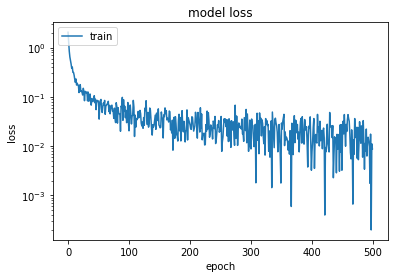

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


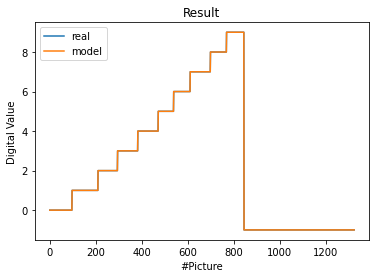

In [6]:
Input_dir='ziffer_sortiert_resize'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpy9riwz6j\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpy9riwz6j\assets


766320

In [8]:
FileName = TFliteNamingAndVersion + "q.tflite"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp2lfqpn59\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp2lfqpn59\assets
C:\Users\Muell\anaconda3\envs\py39-tf-opencv\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


dig1410s1q.tflite


201152

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.